<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Проверка-стационарности-ряда-с-помощбю-теста-Дики-Фуллера" data-toc-modified-id="Проверка-стационарности-ряда-с-помощбю-теста-Дики-Фуллера-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Проверка стационарности ряда с помощбю теста Дики Фуллера</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li></ul></div>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

    
* Описание целей и задачи проекта.Основной целью данного проекта, является - выбор модели для построение предсказаний на основе данных временных рядов
* Описание данных - данные представленны в виде временного ряда и содержат информацию по количеству заказов такси в аэропортах
* План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [ ]:
#импортируем ввсе необходимые библиотеки 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor, cv
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [ ]:
try:
    data = pd.read_csv('/content/drive/MyDrive/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
data = data.sort_index()
data.head(), data.tail()

(                     num_orders
 datetime                       
 2018-03-01 00:00:00           9
 2018-03-01 00:10:00          14
 2018-03-01 00:20:00          28
 2018-03-01 00:30:00          20
 2018-03-01 00:40:00          32,                      num_orders
 datetime                       
 2018-08-31 23:10:00          32
 2018-08-31 23:20:00          24
 2018-08-31 23:30:00          27
 2018-08-31 23:40:00          39
 2018-08-31 23:50:00          53)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data.index.is_monotonic

True

In [ ]:
data = data.resample('1H').sum()


## Проверка стационарности ряда с помощью теста Дики Фуллера

In [ ]:
test = adfuller(data)
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])
if test[0] > test[4]['5%']:
  print('есть единичные корни, ряд не стационарен')
else:
  print ('единичных корней нет, ряд стационарен')

adf: -3.06892428902795
p-value: 0.02894005140261338
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


In [ ]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


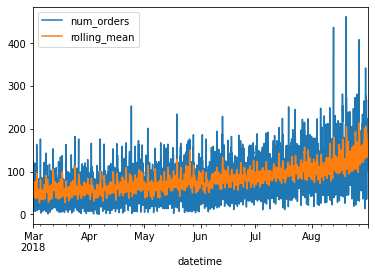

In [ ]:
df = data.copy()
df['rolling_mean'] =  df.rolling(10).mean()
df.plot()

In [ ]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<div class="alert alert-info">добавила функцию агрегации суммирования</div>  

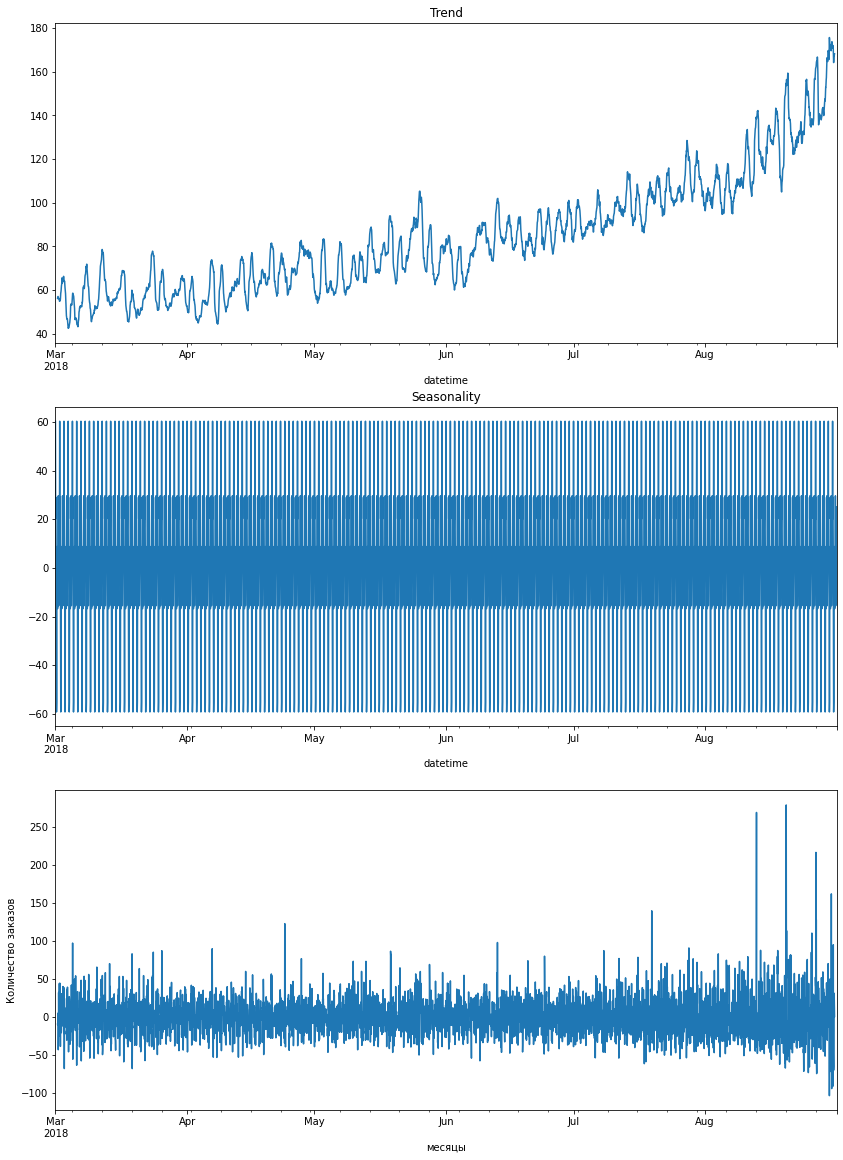

In [ ]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(14, 20))
plt.subplot(311)
plt.gca()

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
ax = plt.gca()

ax.set_xlabel("месяцы")
ax.set_ylabel("Количество заказов")
plt.show()
#plt.title('Residuals')
#plt.tight_layout()

ВЫВОД:Мы видим тренд на увеличение заказов такси в летнее время. Я связываю это с тем, что летом в основном сезон отпусков и совершается больше перелетов чем весной. Больше перелетов - чаще возникает необходимость добраться до аэропорта или из него.

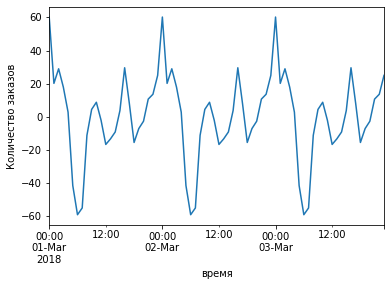

In [ ]:
data.sort_index(inplace=True)
data = data['2018-03':'2018-08'].resample('1H').sum()

decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
ax = plt.gca()

ax.set_xlabel("время")
ax.set_ylabel("Количество заказов")
plt.show()

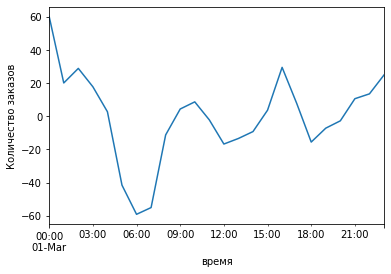

In [ ]:
#data.sort_index(inplace=True)
#data = data['2018-03':'2018-08'].resample('1H').sum()

decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca())
ax = plt.gca()

ax.set_xlabel("время")
ax.set_ylabel("Количество заказов")
plt.show()

ВЫВОД:мы видим опеределнную закономерность во временных промежутках. Пиковые часы заказа такси из или в аэропорт - 12 часов ночи, и дневное время,около 15, с 12 часов ночи до 6 утра идет спад активности. После 6 часов утра количесвто заказов такси постепенно увеличивается. Это связанно с тем, что в ночное время не работает общественный транспорт и уже после 21:00 увеличивается спрос на такси. (возможно, в 6 часов утра санитарный час в аэропорту или туман, который не позволяетни взлететь ни приземлиться)

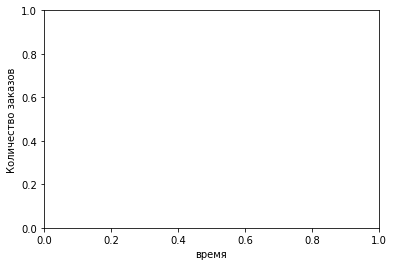

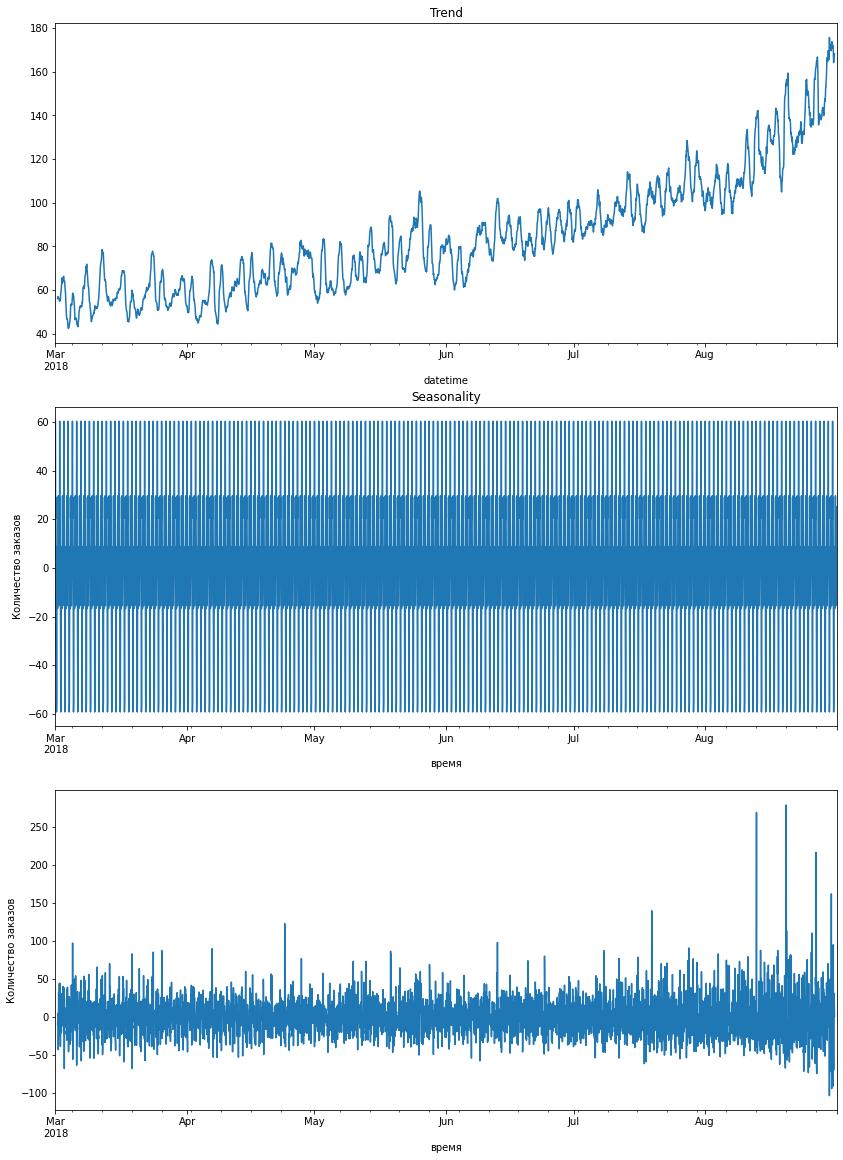

In [ ]:
data_day = data['2018-03-01':'2018-03-02']
data_day = data_day.resample('1H').sum()
decomposed = seasonal_decompose(data) 
ax = plt.gca()

ax.set_xlabel("время")
ax.set_ylabel("Количество заказов")

plt.figure(figsize=(14, 20))
plt.subplot(311)
plt.gca()

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
ax = plt.gca()

ax.set_xlabel("время")
ax.set_ylabel("Количество заказов")

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
ax = plt.gca()

ax.set_xlabel("время")
ax.set_ylabel("Количество заказов")
plt.show()
#plt.title('Residuals')
#plt.tight_layout()

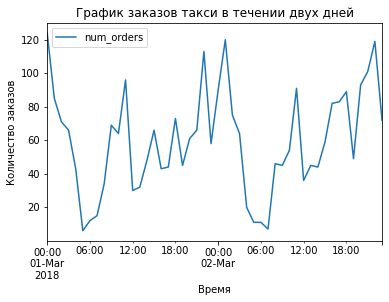

In [ ]:
#data.sort_index(inplace=True)
#data_day = data['2018-03-01':'2018-03-02']
#data_day = data_day.resample('1H').sum()
data_day.plot(title='График заказов такси в течении двух дней')
ax = plt.gca()

ax.set_xlabel("Время")
ax.set_ylabel("Количество заказов")
plt.show()

<div class="alert alert-info">Добавила подписи осей, название графика, убрала технический комментарий (спасибо за совет!)</div> 

ВЫВОД: так как мы рассматриваем весь период, без уточнения, и при этом провели ресемплинго до каждого часа, мы видим, что на графике отображено большое количество часов. Мы видим, что данные представленны с 1 августа 2018 по 31 августа 2018, то есть пол года.Также мы видим, что есть тренд на увеличение заказов постепенно от марта к августу, и пик заказов приходится на август

## Обучение

Так как нам нужно пердсказать количество заказов такси на следующий час, то будет использовать модель Линейная Регрессия.

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(data, 30, 11)

In [ ]:
#разделим данные на обучающую и тестовую выборку
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [ ]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [ ]:
make_features(data, 30, 11)

In [ ]:
#train = train.dropna()
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

In [ ]:
model = LinearRegression()
model.fit(features_train,target_train)
pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

In [ ]:
rmse_lr = mean_squared_error(target_test, pred_test) ** 0.5
rmse_lr

45.122005673854744

ВЫВОД: RMSE меньше 48, значит эта модель и эти гиперпараметры нам походят, для предстказания количества заказов в слудующий час

In [ ]:
model = CatBoostRegressor(
                          loss_function='RMSE',
                          random_seed=42)

grid = {'learning_rate': [0.1, 0.5],
        'depth': [4, 6, 8]}


grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Выходные данные были обрезаны до нескольких последних строк (5000).
26:	learn: 23.9435296	test: 24.1046303	best: 24.1046303 (26)	total: 556ms	remaining: 20s
27:	learn: 23.6610361	test: 23.9287462	best: 23.9287462 (27)	total: 573ms	remaining: 19.9s
28:	learn: 23.3614038	test: 23.7240165	best: 23.7240165 (28)	total: 597ms	remaining: 20s
29:	learn: 23.1029978	test: 23.5326197	best: 23.5326197 (29)	total: 616ms	remaining: 19.9s
30:	learn: 22.8495362	test: 23.4219651	best: 23.4219651 (30)	total: 639ms	remaining: 20s
31:	learn: 22.6947146	test: 23.3308301	best: 23.3308301 (31)	total: 658ms	remaining: 19.9s
32:	learn: 22.4871884	test: 23.1912842	best: 23.1912842 (32)	total: 677ms	remaining: 19.8s
33:	learn: 22.3440439	test: 23.1163959	best: 23.1163959 (33)	total: 695ms	remaining: 19.7s
34:	learn: 22.1987271	test: 23.0308589	best: 23.0308589 (34)	total: 713ms	remaining: 19.7s
35:	learn: 22.0706936	test: 22.9915114	best: 22.9915114 (35)	total: 731ms	remaining: 19.6s
36:	learn: 21.9315667	test: 

In [ ]:
grid_search_result['params']

{'depth': 8, 'learning_rate': 0.1}

In [ ]:
model_cb = CatBoostRegressor(loss_function='RMSE',
                          **grid_search_result['params'],
                          verbose=20,
                          random_seed=42)
model_cb.fit(features_train, target_train)

0:	learn: 36.8517139	total: 26.3ms	remaining: 26.2s
20:	learn: 23.1947780	total: 402ms	remaining: 18.7s
40:	learn: 20.9009133	total: 766ms	remaining: 17.9s
60:	learn: 19.5736431	total: 1.24s	remaining: 19.1s
80:	learn: 18.3647846	total: 1.9s	remaining: 21.6s
100:	learn: 17.5036989	total: 2.29s	remaining: 20.4s
120:	learn: 16.3655538	total: 2.71s	remaining: 19.7s
140:	learn: 15.3306174	total: 3.21s	remaining: 19.6s
160:	learn: 14.2587023	total: 3.59s	remaining: 18.7s
180:	learn: 13.4479072	total: 4s	remaining: 18.1s
200:	learn: 12.6306010	total: 4.53s	remaining: 18s
220:	learn: 12.0563984	total: 5.36s	remaining: 18.9s
240:	learn: 11.4443103	total: 6.18s	remaining: 19.5s
260:	learn: 10.8796729	total: 6.97s	remaining: 19.7s
280:	learn: 10.3427613	total: 7.89s	remaining: 20.2s
300:	learn: 9.9176876	total: 8.83s	remaining: 20.5s
320:	learn: 9.4375477	total: 9.83s	remaining: 20.8s
340:	learn: 9.0247892	total: 10.8s	remaining: 20.8s
360:	learn: 8.6301263	total: 11.5s	remaining: 20.4s
380:	lea

In [ ]:
prediction_test = model_cb.predict(features_test)

In [ ]:
final_RMSE_CB = mean_squared_error(target_test, prediction_test) ** 0.5

In [ ]:
final_RMSE_CB

42.2471447856205

In [ ]:
visio = pd.DataFrame(prediction_test)
visio2 = pd.DataFrame(target_test)
visio.shape, visio2.shape

((442, 1), (442, 1))

In [ ]:
visio = pd.DataFrame({ 
    'pred' : prediction_test,
    'target' : target_test
    })

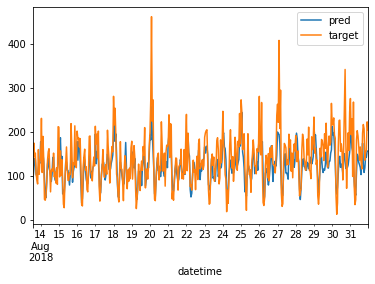

In [ ]:
visio.plot()
plt.show()

ВЫВОД:
* Мы видим, что Cat Boost показывает ниже значение RMSE чем линейная регрессия, значит для предсказаний лучше исспользовать модель Cat Boost. 
* Мы спрогнозировали количество заказов такси на следующий час, темперь компания «Чётенькое такси» готова к новым заказам и может заранее распределить таксистов и машины